In [141]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
import numpy as np
import matplotlib.pyplot as plt


In [142]:
def flatten_images_to_df(images, normalize=True, prefix="px_"):
    """
    images: array (n, h, w)
    -> DataFrame (n, h*w) con columnas px_0..px_(h*w-1)
    """
    X = np.asarray(images, float).reshape(images.shape[0], -1)
    if normalize:
        # en Digits los pixeles están en [0,16]; normalizamos a [0,1]
        X = X / 16.0
    cols = [f"{prefix}{i}" for i in range(X.shape[1])]
    return pd.DataFrame(X, columns=cols)

def flatten_one(img, normalize=True):
    """img (h, w) -> array (1, h*w) listo para predict."""
    x = np.asarray(img, float).reshape(1, -1)
    if normalize:
        x = x / 16.0
    return x

In [143]:
class Mlp:
    def __init__(self, layer_sizes, seed=42):
        self.layer_sizes = layer_sizes
        self.seed = seed
        self.weights = []
        self.biases = []
        self.n_layers = len(layer_sizes)
        self.loss_history = []

    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def dsigmoid_from_a(self, a):
        return a * (1 - a)          # si ya tienes a = sigmoid(z)

    def _ensure_params(self):
        rng = np.random.default_rng(self.seed)
        for l in range(self.n_layers - 1):
            w = rng.normal(0, 0.5, (self.layer_sizes[l], self.layer_sizes[l+1]))
            b = np.zeros((1, self.layer_sizes[l+1]))
            self.weights.append(w)
            self.biases.append(b)

    def forward(self, X):
        A = X
        cache = {"X": X}
        for i in range(self.n_layers - 1):
            Z = A @ self.weights[i] + self.biases[i]
            A = self.sigmoid(Z)
            cache[f"z{i+1}"] = Z
            cache[f"a{i+1}"] = A
        return cache
    
    def backward(self, y, cache):
        zs = [cache[f"z{i+1}"] for i in range(self.n_layers - 1)]
        as_ = [cache[f"a{i+1}"] for i in range(self.n_layers - 1)]
        aL = as_[-1]
        y = np.asarray(y, float)
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        assert y.shape == aL.shape, f"y shape {y.shape} != output shape {aL.shape}"
        n = y.shape[0]

        dz = (aL - y) / n
        dW= [None] * (self.n_layers - 1)
        db= [None] * (self.n_layers - 1)

        for i in reversed(range(self.n_layers - 1)):
            if i == 0:
                a_prev = cache["X"]
            else:
                a_prev = as_[i-1]

            dW[i] = a_prev.T @ dz
            db[i] = np.sum(dz, axis=0, keepdims=True)

            if i > 0:
                da_prev = dz @ self.weights[i].T 
                der = self.dsigmoid_from_a(a_prev)
                dz = da_prev * der
        return dW, db
    
    def step(self, dW, db, lr):
        for i in range(self.n_layers - 1):
            self.weights[i] -= lr * dW[i]
            self.biases[i] -= lr * db[i]

    def fit(self, X, y, lr=0.1, epochs=2000):
        X = np.asarray(X, float)
        y = np.asarray(y, float)
        self.loss_history = []
        self._ensure_params()
        for _ in range(1, epochs + 1):
            cache = self.forward(X)
            aL = cache["a" + str(self.n_layers - 1)]
            loss = np.mean((aL - y) ** 2)
            self.loss_history.append(loss)
            dW, db = self.backward(y, cache)
            self.step(dW, db, lr)
                
    def predict_proba(self, X):
        cache = self.forward(np.asarray(X, float))  
        return cache["a" + str(self.n_layers - 1)]
    
    def predict(self, X, thresh=0.5):
        return (self.predict_proba(X) >= thresh).astype(int)


    # --- NUEVO: predicción de etiquetas para multiclase (argmax) ---
    def predict_labels(self, X):
        proba = self.predict_proba(X)
        if proba.ndim == 2 and proba.shape[1] > 1:
            return proba.argmax(axis=1)
        # si es binario con 1 salida, devuelve {0,1}
        return (proba >= 0.5).astype(int).ravel()

    # --- NUEVO: matriz de confusión (acepta y entero o one-hot) ---
    def confusion_matrix(self, X, y_true):
        y_true = np.asarray(y_true)
        if y_true.ndim == 2 and y_true.shape[1] > 1:
            y_true = y_true.argmax(axis=1)  # de one-hot a índices
        y_pred = self.predict_labels(X)
        n_classes = int(max(y_true.max(), y_pred.max())) + 1
        cm = np.zeros((n_classes, n_classes), dtype=int)
        for t, p in zip(y_true, y_pred):
            cm[t, p] += 1
        return cm

    # --- NUEVO: gráfico del error (MSE) ---
    def plot_loss(self):
        if not hasattr(self, "loss_history") or len(self.loss_history) == 0:
            raise RuntimeError("Aún no hay historial de pérdida. Llama a fit() primero.")
        plt.figure()
        plt.plot(range(1, len(self.loss_history) + 1), self.loss_history)
        plt.xlabel("Épocas")
        plt.ylabel("MSE")
        plt.title("Pérdida de entrenamiento (MSE)")
        plt.tight_layout()
        plt.show()

In [ ]:
digits = load_digits()
digits.data.shape
digits.images[0]


array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

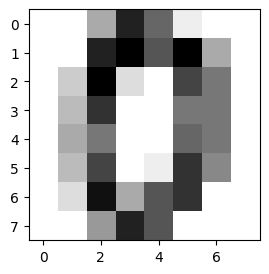

In [145]:
plt.figure(1, figsize=(3, 3))
plt.imshow(digits.images[0], cmap=plt.cm.gray_r, interpolation='nearest')

In [146]:

digits = load_digits()
dfX = flatten_images_to_df(digits.images)     # px_0 .. px_63
df = dfX.assign(label=digits.target)


In [147]:
TEST_FRAC = 0.20
test_df  = df.groupby('label', group_keys=False).sample(frac=TEST_FRAC, random_state=42)
train_df = df.drop(index=test_df.index).reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

In [148]:
train_df

,px_0,px_1,px_2,px_3,px_4,px_5,px_6,px_7,px_8,px_9,...,px_55,px_56,px_57,px_58,px_59,px_60,px_61,px_62,px_63,label
0,0.0,0.0,0.3125,0.8125,0.5625,0.0625,0.0000,0.0,0.0,0.0000,...,0.0,0.0,0.0000,0.3750,0.8125,0.6250,0.0000,0.0000,0.0,0
1,0.0,0.0,0.0000,0.7500,0.8125,0.3125,0.0000,0.0,0.0,0.0000,...,0.0,0.0,0.0000,0.0000,0.6875,1.0000,0.6250,0.0000,0.0,1
2,0.0,0.0,0.0000,0.2500,0.9375,0.7500,0.0000,0.0,0.0,0.0000,...,0.0,0.0,0.0000,0.0000,0.1875,0.6875,1.0000,0.5625,0.0,2
3,0.0,0.0,0.4375,0.9375,0.8125,0.0625,0.0000,0.0,0.0,0.5000,...,0.0,0.0,0.0000,0.4375,0.8125,0.8125,0.5625,0.0000,0.0,3
4,0.0,0.0,0.0000,0.0625,0.6875,0.0000,0.0000,0.0,0.0,0.0000,...,0.0,0.0,0.0000,0.0000,0.1250,1.0000,0.2500,0.0000,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1433,0.0,0.0,0.2500,0.6250,0.8125,0.3750,0.0000,0.0,0.0,0.0625,...,0.0,0.0,0.0000,0.1250,0.8750,0.9375,0.5625,0.0000,0.0,9
1434,0.0,0.0,0.3750,1.0000,0.8125,0.6875,0.0625,0.0,0.0,0.0000,...,0.0,0.0,0.0000,0.3750,1.0000,0.8750,0.3750,0.0000,0.0,0
1435,0.0,0.0,0.0625,0.6875,0.9375,0.0625,0.0000,0.0,0.0,0.0000,...,0.0,0.0,0.0000,0.1250,0.5625,0.8125,0.3750,0.0000,0.0,8
1436,0.0,0.0,0.1250,0.6250,0.4375,0.0000,0.0000,0.0,0.0,0.0000,...,0.0,0.0,0.0000,0.3125,0.7500,1.0000,0.7500,0.0000,0.0,9


In [149]:
X_train = train_df.filter(regex=r'^px_').to_numpy(dtype=float)
y_train_int = train_df['label'].to_numpy(dtype=int)

X_test  = test_df.filter(regex=r'^px_').to_numpy(dtype=float)
y_test_int  = test_df['label'].to_numpy(dtype=int)

# --- normaliza píxeles (Digits: 0..16) ---
X_train /= 16.0
X_test  /= 16.0

# --- y como one-hot (n, 10) para que coincida con la salida sigmoide ---
n_classes = 10
Y_train = np.eye(n_classes, dtype=float)[y_train_int]   # (n,10)
Y_test  = np.eye(n_classes, dtype=float)[y_test_int]    # (m,10)

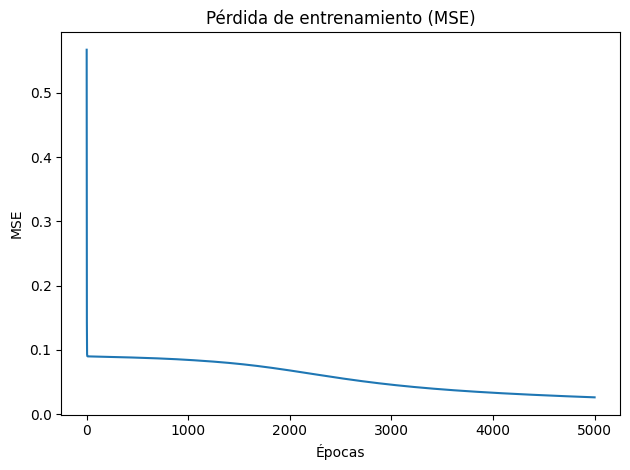

Confusion matrix:
 [[36  0  0  0  0  0  0  0  0  0]
 [ 0 29  0  0  0  0  0  0  2  5]
 [ 1  1 31  2  0  0  0  0  0  0]
 [ 0  0  0 33  0  2  0  2  0  0]
 [ 0  0  0  0 36  0  0  0  0  0]
 [ 0  0  0  0  0 33  0  1  0  2]
 [ 0  2  0  0  0  0 34  0  0  0]
 [ 0  0  0  0  0  1  0 35  0  0]
 [ 0  2  0  0  0  0  0  0 31  2]
 [ 0  0  0  1  0  1  0  1  0 33]]
Accuracy: 0.9220055710306406


In [150]:

mlp = Mlp([64, 128, 64, 10], seed=42)
mlp.fit(X_train, Y_train, lr=0.1, epochs=5000)

mlp.plot_loss()

cm = mlp.confusion_matrix(X_test, Y_test)
print("Confusion matrix:\n", cm)

y_pred = mlp.predict_labels(X_test)
acc = (y_pred == y_test_int).mean()
print("Accuracy:", acc)

In [175]:
mx_num = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 16, 16, 12, 4, 0, 0, 4, 12, 4, 0, 0, 12, 0, 0, 4, 8, 0, 0, 0, 12, 0, 0, 4, 12, 0, 0, 0, 8, 4, 0, 0, 16, 0, 0, 0, 8, 4, 0, 0, 8, 16, 12, 16, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=float).reshape(1,64)
x = np.array(mx_num, dtype=float).reshape(1, 64)  # 0..16
# Si tu X_train estaba en 0..1:
# x = x / 16.0
pred = mlp.predict_proba(x).argmax(axis=1)[0]
print("Predicción:", pred)

Predicción: 0
